# Hierarchical Models

We will model the number of chocolate chips in cookies made at 5 different bakeries. There are 150 cookies in all, 30 from each bakery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm

from scipy.special import expit

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

The `cookies.dat` file is available from within the course from a cloudfront location, but not sure if it will be accessible outside the course or after the course ends, so in the interest of reproducibility, I have made a local copy.

In [3]:
cookies_df = pd.read_csv("cookies.dat", sep=" ")
cookies_df.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


## Visualize Data

* 5 locations
* 30 cookies from each location
* location 5 most generous with chips / cookie

In [4]:
cookies_df.groupby("location").count()

,chips
location,
1,30
2,30
3,30
4,30
5,30


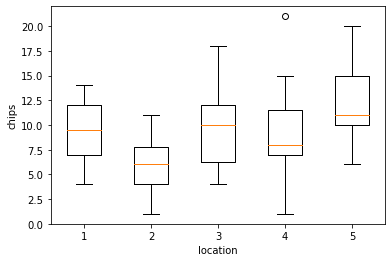

In [5]:
locations = np.arange(1, 6)
data = [cookies_df[cookies_df["location"].values == location]["chips"] for location in locations]
plt.boxplot(data, labels=[str(l) for l in locations])
plt.ylabel("chips")
plt.xlabel("location")
_ = plt.show()

## Define Model

We define our hierarchical location-dependent model using the following equations.

$$ y_{i,j} \bar \lambda_j \overset{\text{ind}}{\sim} Poisson(\lambda_j) \;\; i=1,..,30, j=1,..,5 $$

$$ \lambda_j \overset{\text{iid}}{\sim} Gamma(\alpha, \beta) \;\; j=1,..,5 $$

$$ \alpha \sim p(\alpha), \beta \sim p(\beta) $$

Here $\alpha$ and $\beta$ are priors we will need to choose. Rather than specify them directly, we will specify them in terms of two new prior distributions $\mu$ and $\sigma$, as follows:

$$ \mu \sim Gamma(\alpha=2, \beta=0.2) $$

$$ \sigma \sim Exponential(\lambda=1.0) $$

The setting for $\mu$ sets the mean of the distribution at 10 ($\alpha$ / $\beta$) which is approximately what we see from the boxplot above. It is possible to compute the values of $\alpha$ and $\beta$ distributions using the formulas:

$$ \mu = \frac{\alpha}{\beta} $$

$$ \sigma^2 = \frac{\alpha}{\beta^2} $$

Findings from the model:
* the `loc_lams[i]` values show the mean number of chocolate chips per cookie at each of the different locations, and roughly corresponds to what we see in the boxplots.`
* the `\global_mu` is the mean of the different `loc_lam` values, and indicates the degree of similarity between the different locations, while `\global_sig` is the standard deviation, and indicates the degree of difference among different locations.

In [6]:
data = np.array([np.array(cookies_df[cookies_df["location"].values == location]["chips"]) 
                 for location in locations])
num_locations = data.shape[0]
data.shape

(5, 30)

In [7]:
model_1 = pm.Model()
with model_1:
    global_mu = pm.Gamma("global_mu", alpha=2, beta=0.2)
    global_sig = pm.Exponential("global_sig", lam=1.0)
    
    alpha = pm.Deterministic("alpha", pm.math.sqr(global_mu) / pm.math.sqr(global_sig))
    beta = pm.Deterministic("beta", global_mu / pm.math.sqr(global_sig))
    
    loc_lams = pm.Gamma("loc_lams", alpha=alpha, beta=beta, shape=num_locations)
    
    yloc0_obs = pm.Poisson("yloc0_obs", mu=loc_lams[0], observed=data[0])
    yloc1_obs = pm.Poisson("yloc1_obs", mu=loc_lams[1], observed=data[1])
    yloc2_obs = pm.Poisson("yloc2_obs", mu=loc_lams[2], observed=data[2])
    yloc3_obs = pm.Poisson("yloc3_obs", mu=loc_lams[3], observed=data[3])
    yloc4_obs = pm.Poisson("yloc4_obs", mu=loc_lams[4], observed=data[4])
    
    trace_1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [loc_lams, global_sig, global_mu]
Sampling 4 chains, 2 divergences: 100%|██████████| 24000/24000 [00:23<00:00, 1042.21draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


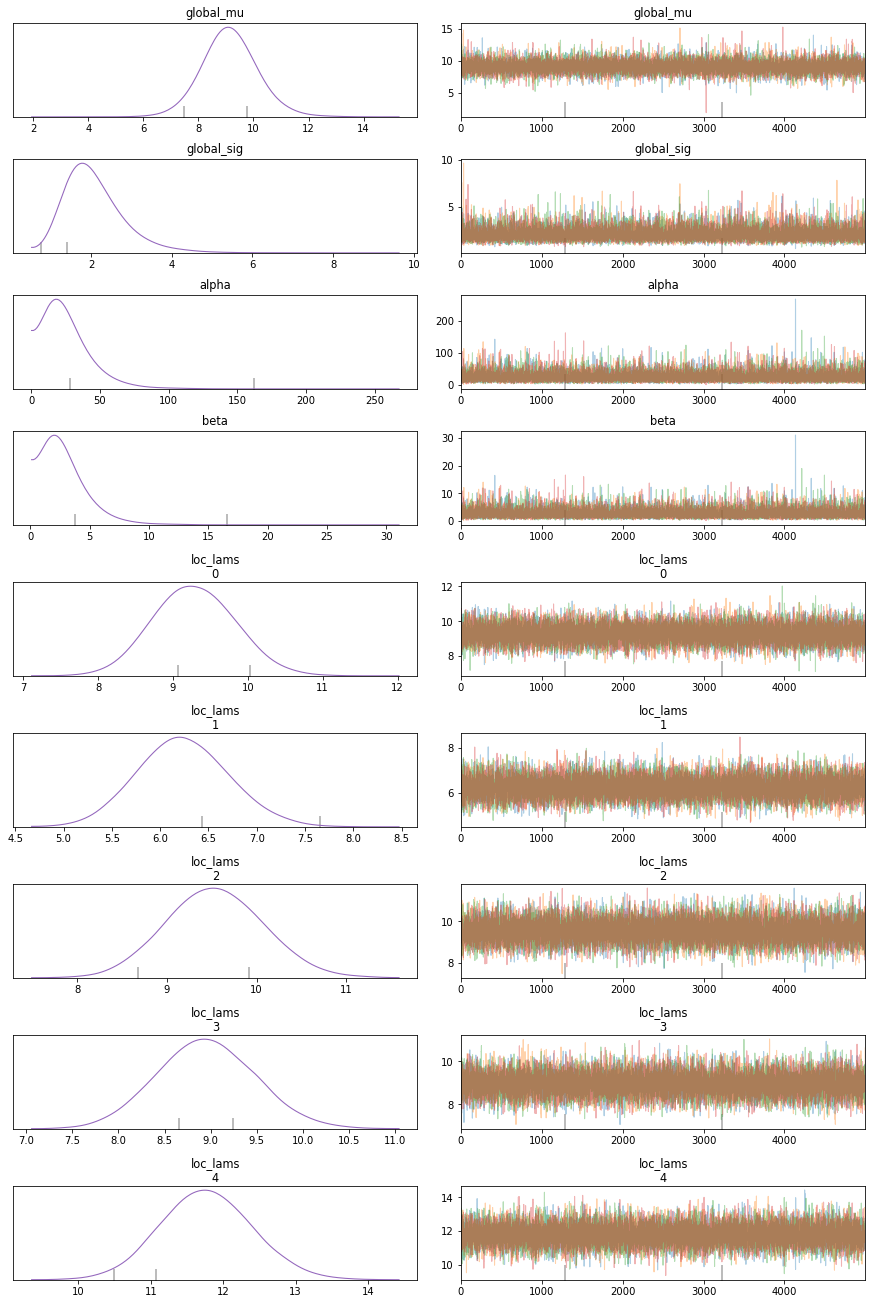

In [8]:
_ = pm.traceplot(trace_1, combined=True, compact=False)

In [9]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
global_mu,9.111,0.969,7.272,10.915,0.008,0.006,15030.0,15030.0,16206.0,12481.0,1.0
global_sig,2.071,0.715,0.956,3.382,0.006,0.005,13970.0,12312.0,15184.0,12471.0,1.0
alpha,25.752,16.688,3.588,55.845,0.140,0.107,14131.0,12095.0,15276.0,12529.0,1.0
beta,2.837,1.836,0.365,6.087,0.016,0.012,13964.0,11975.0,15125.0,12672.0,1.0
loc_lams[0],9.274,0.536,8.276,10.269,0.004,0.002,23080.0,23080.0,22907.0,14742.0,1.0
loc_lams[1],6.232,0.464,5.365,7.102,0.003,0.002,20477.0,20388.0,20472.0,14813.0,1.0
loc_lams[2],9.525,0.536,8.530,10.535,0.004,0.003,21568.0,21568.0,21532.0,14511.0,1.0
loc_lams[3],8.946,0.527,7.953,9.931,0.004,0.003,20120.0,20068.0,20051.0,14421.0,1.0
loc_lams[4],11.760,0.625,10.595,12.939,0.004,0.003,20234.0,20234.0,20177.0,14231.0,1.0


## Residual Analysis

Two levels of residuals:
* Observation level (`y_loc*_obs`)
* Lambda level (`loc_lams`)

Findings for observation level residual plots:
* No discernible pattern in the first residual plot, which is good.
* For second residual plot, increase in variance of residual noticed with higher predictions, but this is expected since we are working with Poisson likelihood, where variance increases as mean increases.

Findings for lambda level residual plots:
* Again no discernible pattern for residuals, which is good.

In [10]:
loc_lams = np.mean(trace_1.get_values("loc_lams"), axis=0)
cookies_df["preds"] = loc_lams[cookies_df["location"] - 1]
cookies_df["resids"] = cookies_df["chips"] - cookies_df["preds"]
cookies_df.head()

,chips,location,preds,resids
0,12,1,9.273881,2.726119
1,12,1,9.273881,2.726119
2,6,1,9.273881,-3.273881
3,13,1,9.273881,3.726119
4,12,1,9.273881,2.726119


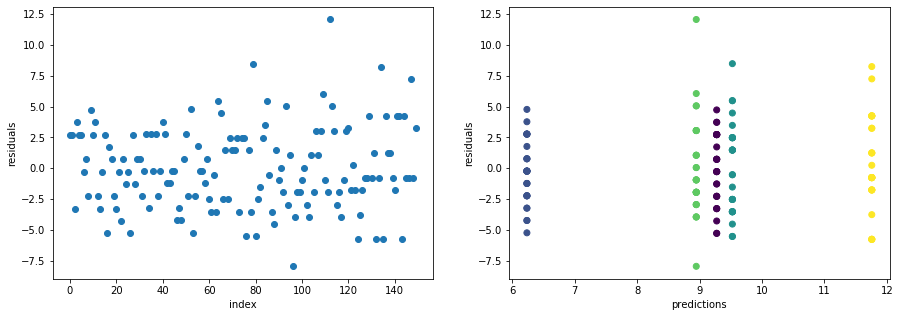

In [11]:
preds = cookies_df["preds"].values
resids = cookies_df["resids"].values
colors = cookies_df["location"].values

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(np.arange(len(resids)), resids)
plt.xlabel("index")
plt.ylabel("residuals")

plt.subplot(122)
plt.scatter(preds, resids, c=colors)
plt.xlabel("predictions")
plt.ylabel("residuals")

_ = plt.show()

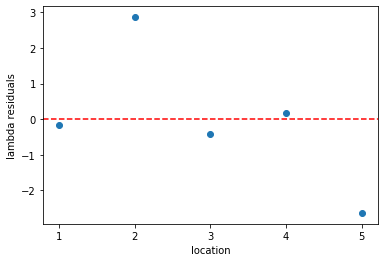

In [12]:
global_mu = np.mean(trace_1.get_values("global_mu"), axis=0)
global_resids = global_mu - loc_lams

plt.scatter(np.arange(len(global_resids)), global_resids)
plt.xlabel("location")
plt.xticks(np.arange(0, 5), np.arange(0, 5) + 1)
plt.ylabel("lambda residuals")
plt.axhline(y=0, xmin=0, xmax=4, c="r", linestyle="--")

_ = plt.show()

# global_resids.shape

## Posterior Predictive Simulation

### 1. Simulate Posterior distribution for new location

We have declared $\alpha$ and $\beta$ as `pm.Deterministic` so we can access their posterior distributions through the trace, otherwise we would have to use the posterior distributions of $\mu$ and $\sigma$ to calculate $\alpha$ and $\beta$, then simulate the posterior distribution for $\lambda$ at a new location using these.

In [13]:
alpha = trace_1.get_values("alpha")
beta = trace_1.get_values("beta")
n_sims = len(alpha)

lam_pred = stats.gamma.rvs(alpha, scale=1/beta, size=n_sims)

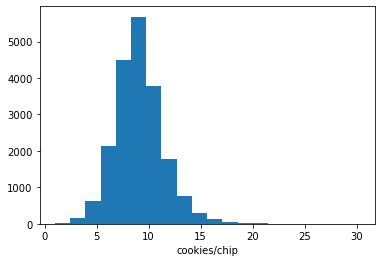

In [14]:
plt.hist(lam_pred, bins=20)
plt.xlabel("cookies/chip")
_ = plt.show()

### 2. Probability of having >15 chips/cookie (lambda > 15) at new location

In [15]:
np.mean(lam_pred > 15)

0.01755

### 3. Simulate Posterior Distribution for new cookie (any location)

In [16]:
y_pred = stats.poisson.rvs(lam_pred, size=n_sims)

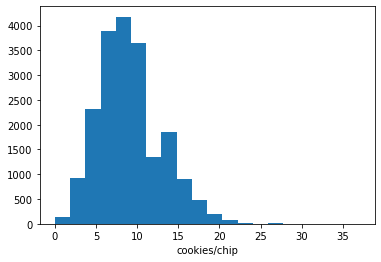

In [17]:
plt.hist(y_pred, bins=20)
plt.xlabel("cookies/chip")
_ = plt.show()

### 4. Probability of having cookie with >15 chips

In [18]:
np.mean(y_pred > 15)

0.0578

### 5. Probability of next cookie at location 1 having <7 chips

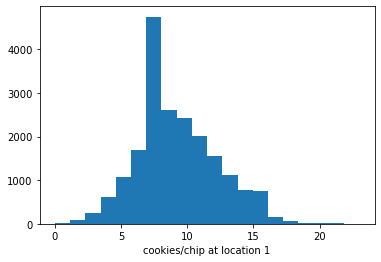

In [19]:
yloc0_pred = stats.poisson.rvs(loc_lams[0], size=n_sims)

plt.hist(yloc0_pred, bins=20)
plt.xlabel("cookies/chip at location 1")
_ = plt.show()

In [20]:
np.mean(yloc0_pred < 7)

0.1861